In [9]:
import pandas as pd
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import cdist, pdist
from scipy.cluster.vq import kmeans
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

## Modelo a implementar: Kmeans
Archivo fuente: usuarios twitter.csv
Objetivo: agrupar usuarios por sus rasgos de personalidad
Variable de entrada: crea tu modelo seleccionando solo 3 características
- usuario: nombre en Twitter
- "op": Openness to experience — grado de apertura mental a nuevas experiencias, curiosidad, arte
- "co": Conscientiousness — grado de orden, prolijidad, organización
- "ex": Extraversion — grado de timidez, solitario o participación ante el grupo social
- "ag": Agreeableness — grado de empatía con los demás, temperamento
- "ne": Neuroticism, — grado de neuroticismo, nervioso, irritabilidad, seguridad en sí mismo.
- Wordcoun: Cantidad promedio de palabras usadas en sus tweets

Variable de salida: Categoría — Actividad laboral del usuario (1. Actor/actriz, 2. Cantante, 3. Modelo, 4. Tv, series, 5. Radio, 6. Tecnología, 7. Deportes, 8. Politica y 9. Escritor)
¿Cuál es el número adecuado de cluster?
¿Qué interpretación le dan a los grupos que se han formado?

In [10]:
data = pd.read_csv('./data/usuarios-twitter.csv', delimiter=',', encoding='utf-8-sig')

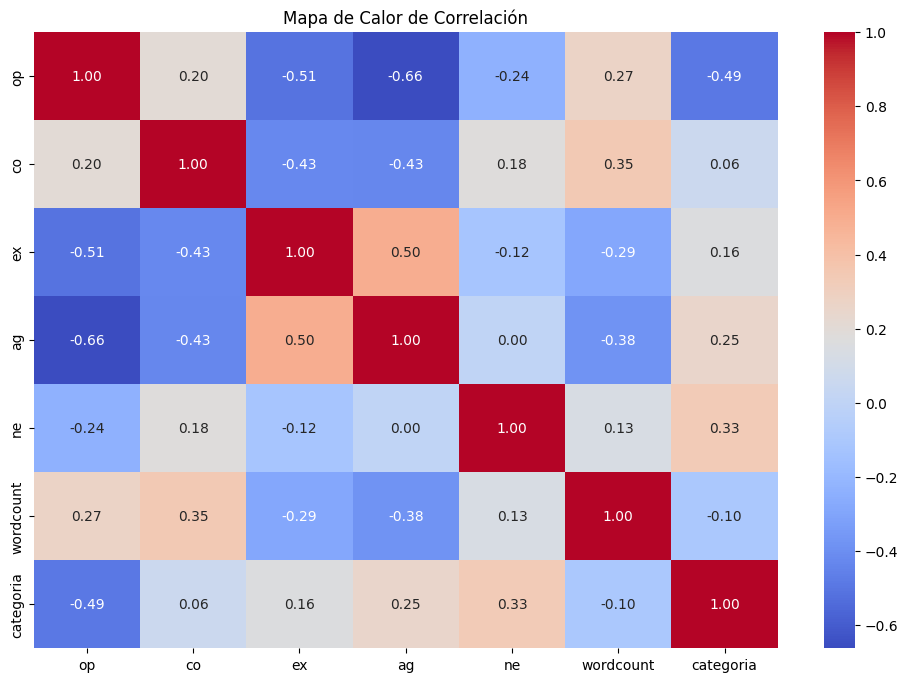

,op,co,ex,ag,ne,wordcount,categoria
op,1.000000,0.204787,-0.508838,-0.662599,-0.238146,0.270123,-0.491178
co,0.204787,1.000000,-0.425614,-0.431095,0.180469,0.346416,0.061700
ex,-0.508838,-0.425614,1.000000,0.497006,-0.118141,-0.291869,0.160371
ag,-0.662599,-0.431095,0.497006,1.000000,0.003082,-0.381874,0.252489
ne,-0.238146,0.180469,-0.118141,0.003082,1.000000,0.134665,0.333581
wordcount,0.270123,0.346416,-0.291869,-0.381874,0.134665,1.000000,-0.097727
categoria,-0.491178,0.061700,0.160371,0.252489,0.333581,-0.097727,1.000000


In [11]:
# Mapa de Calor de Correlación
plt.figure(figsize=(12, 8))
correlation_matrix = data.corr(numeric_only=True)
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Mapa de Calor de Correlación")
plt.show()
display(pd.DataFrame(correlation_matrix))

,Número de grupos,WCSS (Suma total de cuadrados dentro del grupo),BCSS (Suma total de cuadrados entre grupos),TSS (Suma total de cuadrados),Porcentaje de varianza explicada
0,1,25194.039353,-6.184564e-11,25194.039353,-2.454773e-13
1,2,12632.031537,1.256201e+04,25194.039353,4.986103e+01
2,3,10017.620571,1.517642e+04,25194.039353,6.023813e+01
3,4,8398.729028,1.679531e+04,25194.039353,6.666383e+01
4,5,6978.463650,1.821558e+04,25194.039353,7.230113e+01
5,6,6101.661951,1.909238e+04,25194.039353,7.578133e+01
6,7,5776.766521,1.941727e+04,25194.039353,7.707090e+01
7,8,5034.097129,2.015994e+04,25194.039353,8.001870e+01
8,9,4432.629886,2.076141e+04,25194.039353,8.240604e+01


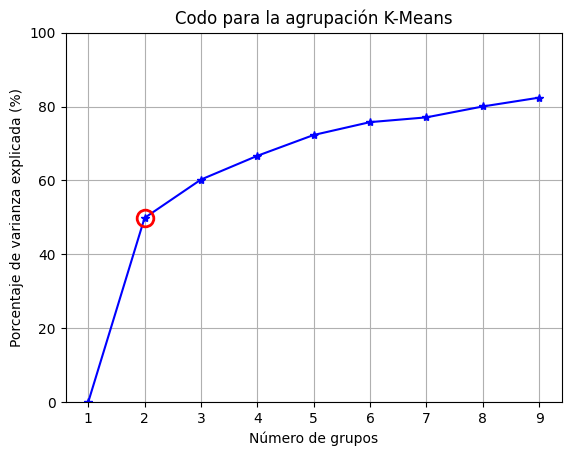

El número adecuado de clusters se puede determinar observando el punto en el que la variación de la suma total entre clusters (BCSS) comienza a disminuir significativamente. 
En este caso, el número óptimo de clusters es 2.


In [23]:
X = data[["op", "ex", "ag"]]

# Clusterizar datos en K=1..9 grupos
K_MAX = 9
KK = range(1, K_MAX + 1)

KM = [kmeans(X, k) for k in KK]
centroids = [cent for (cent, var) in KM]
D_k = [cdist(X, cent, 'euclidean') for cent in centroids]
cIdx = [np.argmin(D, axis=1) for D in D_k]
dist = [np.min(D, axis=1) for D in D_k]

tot_withinss = [sum(d**2) for d in dist]
totss = sum(pdist(X)**2) / X.shape[0]
betweenss = totss - tot_withinss

# Crear un DataFrame con los resultados
resultados_df = pd.DataFrame({
    "Número de grupos": list(KK),
    "WCSS (Suma total de cuadrados dentro del grupo)": tot_withinss,
    "BCSS (Suma total de cuadrados entre grupos)": betweenss,
    "TSS (Suma total de cuadrados)": [totss] * K_MAX,  # Corregido
    "Porcentaje de varianza explicada": [betweenss[k] / totss * 100 for k in range(K_MAX)]
})

# Mostrar el DataFrame con los resultados
display(resultados_df)

# Plots
kIdx = 1  # K=10
mrk = 'os^p<dvh8>+x.'

# Curva del codo
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(KK, betweenss / totss * 100, 'b*-')
ax.plot(KK[kIdx], betweenss[kIdx] / totss * 100, marker='o', markersize=12,
        markeredgewidth=2, markeredgecolor='r', markerfacecolor='None')
ax.set_ylim((0, 100))
plt.grid(True)
plt.xlabel('Número de grupos')
plt.ylabel('Porcentaje de varianza explicada (%)')
plt.title('Codo para la agrupación K-Means')
plt.show()

# Explicación del número adecuado de clusters
explicacion = "El número adecuado de clusters se puede determinar observando el punto en el que la variación de la suma total entre clusters (BCSS) comienza a disminuir significativamente. \nEn este caso, el número óptimo de clusters es 2."

print(explicacion)


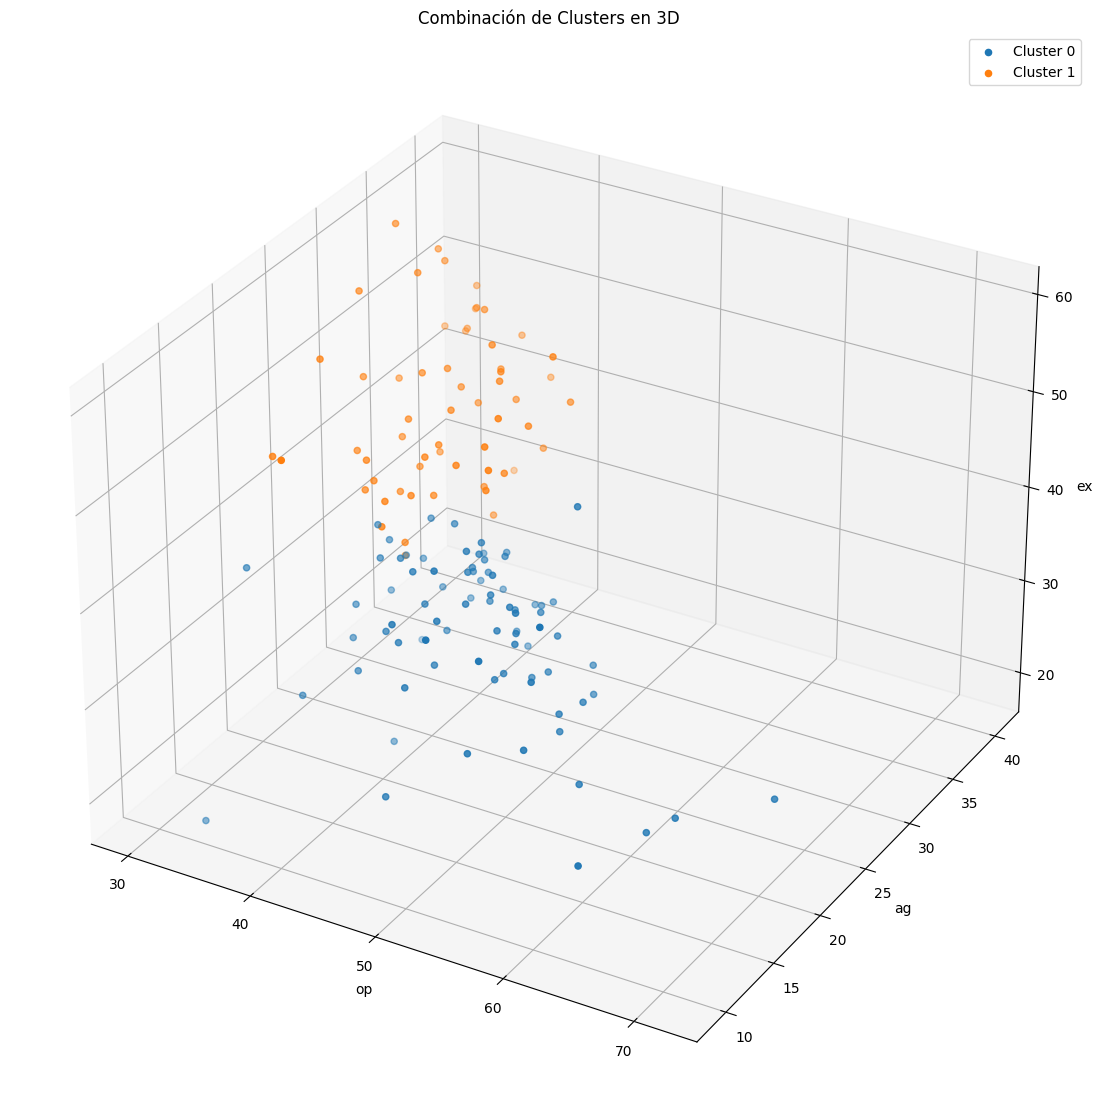

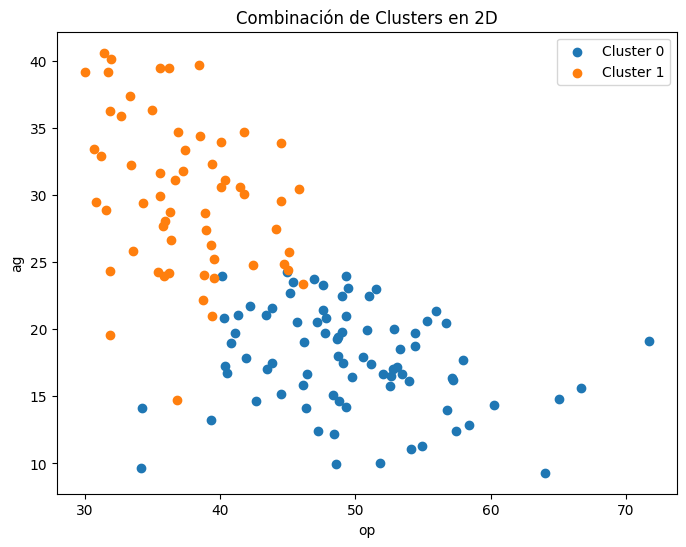

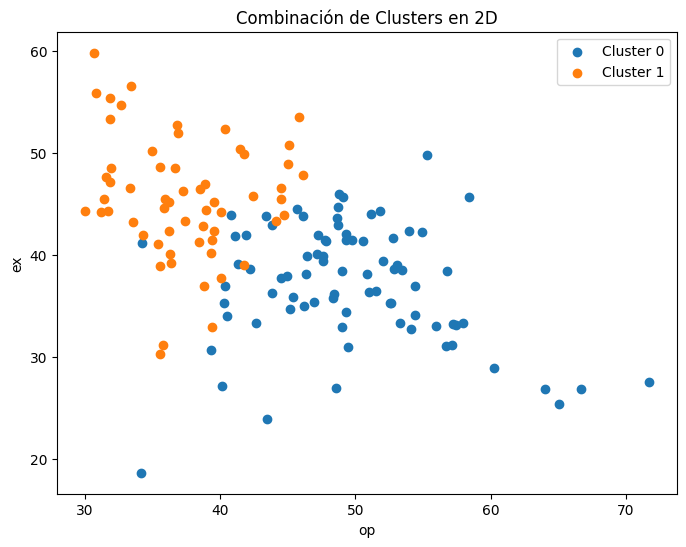

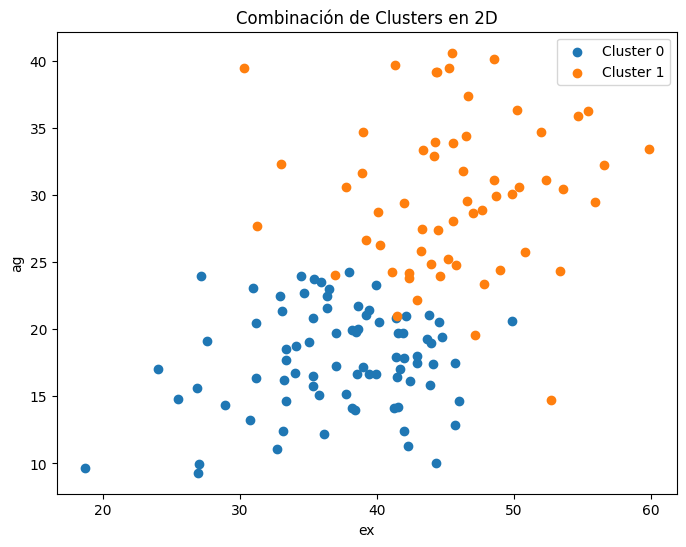

,usuario,op,co,ex,ag,ne,wordcount,categoria,Cluster,cluster
0,3gerardpique,34.297953,28.148819,41.948819,29.370315,9.841575,37.0945,7,1,1
1,aguerosergiokun,44.986842,20.525865,37.938947,24.279098,10.362406,78.7970,7,0,0
2,albertochicote,41.733854,13.745417,38.999896,34.645521,8.836979,49.2604,4,1,1
3,AlejandroSanz,40.377154,15.377462,52.337538,31.082154,5.032231,80.4538,2,1,1
4,alfredocasero1,36.664677,19.642258,48.530806,31.138871,7.305968,47.0645,4,1,1
...,...,...,...,...,...,...,...,...,...,...
135,XabiAlonso,35.569389,22.133740,38.904885,31.624351,12.201221,47.5420,7,1,1
136,XaviRodriguez,31.960417,15.416979,48.533125,40.096458,11.764583,47.5625,4,1,1
137,xoellopez,71.696129,12.489274,27.571210,19.093548,3.241935,74.3065,2,0,0
138,ZacEfron,51.537405,26.009695,36.465344,23.008168,7.284962,118.6107,1,0,0


In [54]:
# Seleccionar las características adecuadas
features = data[["op", "ag", "ex"]]

# Estandarizar las características
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

optimal_clusters = 2

kmeans = KMeans(n_clusters=optimal_clusters, random_state=0, max_iter=1000)
cluster_labels = kmeans.fit_predict(scaled_features)

data['cluster'] = cluster_labels

# Función para graficar combinaciones de clusters en 3D
def plot_3d_clusters(data, x_label, y_label, z_label):
    fig = plt.figure(figsize=(16, 14))
    ax = fig.add_subplot(111, projection='3d')

    for cluster in set(data['cluster']):
        cluster_data = data[data['Cluster'] == cluster]
        ax.scatter(cluster_data[x_label], cluster_data[y_label], cluster_data[z_label], label=f'Cluster {cluster}')

    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_zlabel(z_label)
    plt.legend(loc='best')
    plt.title('Combinación de Clusters en 3D')
    plt.show()

# Función para graficar combinaciones de clusters en 2D
def plot_2d_clusters(data, x_label, y_label):
    plt.figure(figsize=(8, 6))

    for cluster in set(data['Cluster']):
        cluster_data = data[data['Cluster'] == cluster]
        plt.scatter(cluster_data[x_label], cluster_data[y_label], label=f'Cluster {cluster}')

    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend(loc='best')
    plt.title('Combinación de Clusters en 2D')
    plt.show()

# Combinación de clusters en 3D
x_label_3d = "op"
y_label_3d = "ag"
z_label_3d = "ex"
plot_3d_clusters(data, x_label_3d, y_label_3d, z_label_3d)

# Combinación de clusters en 2D
x_label_2d = "op"
y_label_2d = "ag"
plot_2d_clusters(data, x_label_2d, y_label_2d)

# Combinación de clusters en 2D
x_label_2d = "op"
y_label_2d = "ex"
plot_2d_clusters(data, x_label_2d, y_label_2d)

# Combinación de clusters en 2D
x_label_2d = "ex"
y_label_2d = "ag"
plot_2d_clusters(data, x_label_2d, y_label_2d)

display(data)


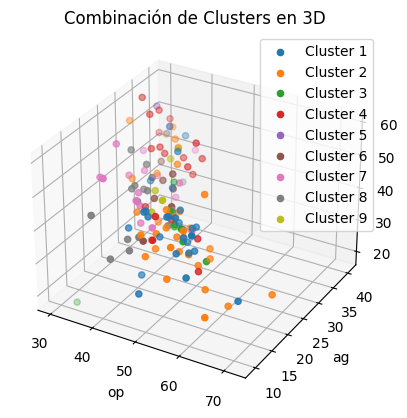

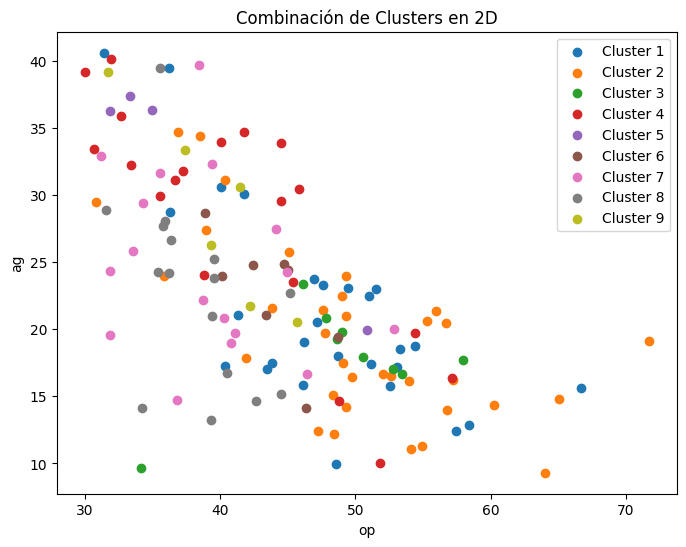

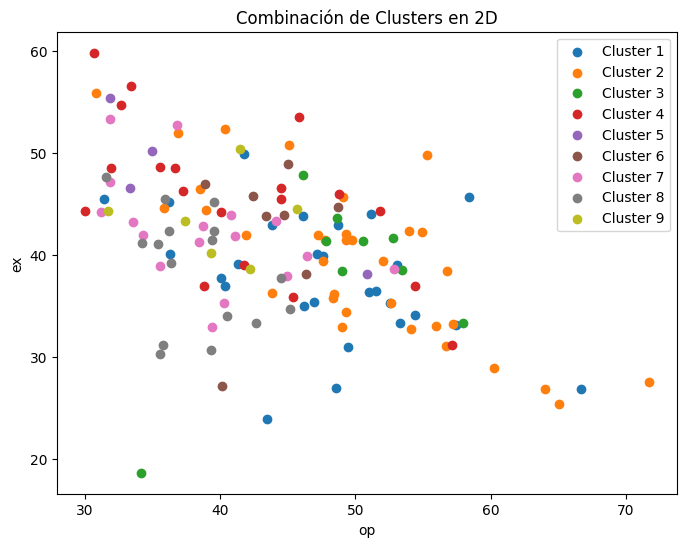

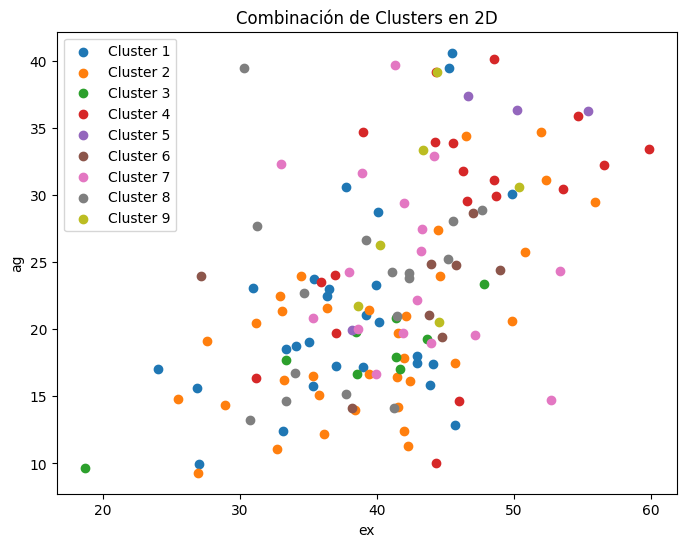

In [55]:

# Seleccionar las características adecuadas
features = data[["op", "ag", "ex"]]

# Estandarizar las características
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

optimal_clusters = 2

kmeans = KMeans(n_clusters=optimal_clusters, random_state=0, max_iter=1000)
cluster_labels = kmeans.fit_predict(scaled_features)

data['cluster'] = data['categoria']# cluster_labels

# Función para graficar combinaciones de clusters en 3D
def plot_3d_clusters(data, x_label, y_label, z_label):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    for cluster in set(data['categoria']):
        cluster_data = data[data['categoria'] == cluster]
        ax.scatter(cluster_data[x_label], cluster_data[y_label], cluster_data[z_label], label=f'Cluster {cluster}')

    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_zlabel(z_label)
    plt.legend(loc='best')
    plt.title('Combinación de Clusters en 3D')
    plt.show()

# Función para graficar combinaciones de clusters en 2D
def plot_2d_clusters(data, x_label, y_label):
    plt.figure(figsize=(8, 6))

    for cluster in set(data['categoria']):
        cluster_data = data[data['categoria'] == cluster]
        plt.scatter(cluster_data[x_label], cluster_data[y_label], label=f'Cluster {cluster}')

    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend(loc='best')
    plt.title('Combinación de Clusters en 2D')
    plt.show()

# Combinación de clusters en 3D
x_label_3d = "op"
y_label_3d = "ag"
z_label_3d = "ex"
plot_3d_clusters(data, x_label_3d, y_label_3d, z_label_3d)

# Combinación de clusters en 2D
x_label_2d = "op"
y_label_2d = "ag"
plot_2d_clusters(data, x_label_2d, y_label_2d)

# Combinación de clusters en 2D
x_label_2d = "op"
y_label_2d = "ex"
plot_2d_clusters(data, x_label_2d, y_label_2d)

# Combinación de clusters en 2D
x_label_2d = "ex"
y_label_2d = "ag"
plot_2d_clusters(data, x_label_2d, y_label_2d)


### No hay manera de asociar las cstegorías con lso clusters generados por la gran disperción de los datos, por tal motivo solo podemos interpretar la cantidad de clusters que se generan y la asociación entre las características seleccionadas.

Se puede interpretar de la gráfica 3D de los clusters, que una persona tímida, con poca empatía y con poca apertura mental, se asocia al cluster 0, mientras que una persona con mucha empatía, con mucha apertura mental y con poca timidez, se asocia al cluster 1.

## Modelo a implementar: RNA. Deben realizar una búsqueda de hiperparámetros mediante
GridSearchCV or RandomizedSearchCV. Utilicen 5 K-Fold validación cruzada.
Datos: Se simulan observaciones en dos dimensiones, pertenecientes a tres grupos, cuya
separación no es perfecta.
from sklearn.datasets import make_blobs


```X, y = make_blobs(
n_samples = 500,
n features = 2,
centers = 3,
cluster std = 1.2,
shuffle = True,
random state = 0)
```

Objetivo: clasificar a qué grupo pertenece cada muestra
¿Cuál es la configuración de la RNA que te generó mejor accuracy?

Mejores hiperparámetros para RNA encontrados: {'activation': 'relu', 'hidden_layer_sizes': (5, 5), 'max_iter': 10000, 'random_state': 0, 'solver': 'sgd'}
Precisión (accuracy) con los mejores hiperparámetros para RNA: 0.8780000000000001
Mejor modelo para RNA:
MLPClassifier(hidden_layer_sizes=(5, 5), max_iter=10000, random_state=0,
              solver='sgd')

Explicación para RNA:
El mejor modelo para la RNA se eligió según la precisión (accuracy) obtenida en la validación cruzada.
Los mejores hiperparámetros encontrados para la RNA son los siguientes:
activation: relu
hidden_layer_sizes: (5, 5)
max_iter: 10000
random_state: 0
solver: sgd
La precisión obtenida con estos hiperparámetros para la RNA es: 0.8780000000000001


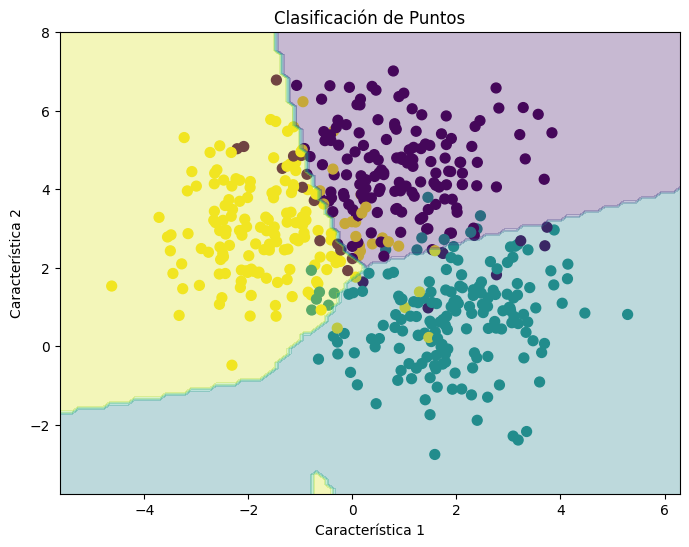

In [21]:


# Genera los datos
X, y = make_blobs(
    n_samples=500,
    n_features=2,
    centers=3,
    cluster_std=1.2,
    shuffle=True,
    random_state=0,
)

# Define el espacio de búsqueda de hiperparámetros para la RNA
param_grid = {
    "hidden_layer_sizes": [(5, 5), (10, 10), (15, 15), (20, 20), (50, 50)],
    "activation": ["relu", "logistic"],
    "solver": ["adam", "sgd", "lbfgs"],
    "max_iter": [1000, 10000],
    "random_state": [0, 1],
}

# Crea el modelo de RNA
mlp = MLPClassifier()

# Utiliza GridSearchCV para encontrar la mejor configuración de hiperparámetros para la RNA
grid_search_rna = GridSearchCV(mlp, param_grid, cv=5, scoring="accuracy", n_jobs=-1)
grid_search_rna.fit(X, y)

# Obtiene los resultados de todas las iteraciones en un DataFrame para la RNA
results_df_rna = pd.DataFrame(grid_search_rna.cv_results_).iloc[:, 4:]

# Muestra la mejor configuración de hiperparámetros encontrada para la RNA
best_params_rna = grid_search_rna.best_params_
best_accuracy_rna = grid_search_rna.best_score_
print("Mejores hiperparámetros para RNA encontrados:", best_params_rna)
print("Precisión (accuracy) con los mejores hiperparámetros para RNA:", best_accuracy_rna)

# Imprime el mejor modelo para la RNA
best_model_rna = grid_search_rna.best_estimator_
print("Mejor modelo para RNA:")
print(best_model_rna)

# Imprime una explicación para la RNA
print("\nExplicación para RNA:")
print("El mejor modelo para la RNA se eligió según la precisión (accuracy) obtenida en la validación cruzada, debido su alto puntaje y simplicidad.")
print("Los mejores hiperparámetros encontrados para la RNA son los siguientes:")
for param, value in best_params_rna.items():
    print(f"{param}: {value}")
print("La precisión obtenida con estos hiperparámetros para la RNA es:", best_accuracy_rna)

# Grafica los puntos con sus clases
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis", marker="o", s=50)
plt.title("Clasificación de Puntos")
plt.xlabel("Característica 1")
plt.ylabel("Característica 2")

# Crea una malla de puntos para visualizar las fronteras de decisión
xx, yy = np.meshgrid(
    np.linspace(X[:, 0].min() - 1, X[:, 0].max() + 1, 100),
    np.linspace(X[:, 1].min() - 1, X[:, 1].max() + 1, 100),
)
Z = best_model_rna.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Dibuja las fronteras de decisión para la RNA
plt.contourf(xx, yy, Z, alpha=0.3, cmap="viridis")
plt.show()

In [30]:
results_df_rna

,param_activation,param_hidden_layer_sizes,param_max_iter,param_random_state,param_solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,param_hidden_layer_sizes_0
0,relu,"(5, 5)",1000,0,adam,"{'activation': 'relu', 'hidden_layer_sizes': (...",0.85,0.86,0.92,0.86,0.84,0.866,0.028000,52,5
1,relu,"(5, 5)",1000,0,sgd,"{'activation': 'relu', 'hidden_layer_sizes': (...",0.85,0.85,0.90,0.89,0.84,0.866,0.024166,52,5
2,relu,"(5, 5)",1000,0,lbfgs,"{'activation': 'relu', 'hidden_layer_sizes': (...",0.88,0.86,0.90,0.85,0.82,0.862,0.027129,65,5
3,relu,"(5, 5)",1000,1,adam,"{'activation': 'relu', 'hidden_layer_sizes': (...",0.88,0.87,0.94,0.86,0.82,0.874,0.038781,13,5
4,relu,"(5, 5)",1000,1,sgd,"{'activation': 'relu', 'hidden_layer_sizes': (...",0.87,0.86,0.89,0.88,0.82,0.864,0.024166,60,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,logistic,"(50, 50)",10000,0,sgd,"{'activation': 'logistic', 'hidden_layer_sizes...",0.86,0.88,0.92,0.88,0.75,0.858,0.057411,70,50
116,logistic,"(50, 50)",10000,0,lbfgs,"{'activation': 'logistic', 'hidden_layer_sizes...",0.87,0.82,0.85,0.86,0.80,0.840,0.026077,91,50
117,logistic,"(50, 50)",10000,1,adam,"{'activation': 'logistic', 'hidden_layer_sizes...",0.89,0.89,0.93,0.85,0.82,0.876,0.037736,9,50
118,logistic,"(50, 50)",10000,1,sgd,"{'activation': 'logistic', 'hidden_layer_sizes...",0.86,0.87,0.93,0.88,0.85,0.878,0.027857,2,50
